In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler

In [2]:
!jupyter --version

jupyter core     : 4.7.1
jupyter-notebook : 6.4.3
qtconsole        : 5.1.0
ipython          : 7.26.0
ipykernel        : 6.2.0
jupyter client   : 6.1.12
jupyter lab      : not installed
nbconvert        : 6.1.0
ipywidgets       : 7.6.3
nbformat         : 5.1.3
traitlets        : 5.0.5


In [3]:
import pkg_resources
import sys
print("Pandas: " + pkg_resources.get_distribution("pandas").version)
print("NumPy: " + pkg_resources.get_distribution("numpy").version)
print("MatPlotLib: " + pkg_resources.get_distribution("matplotlib").version)
print("Seaborn: " + pkg_resources.get_distribution("seaborn").version)
print("Scikit-Learn: " + pkg_resources.get_distribution("scikit-learn").version)
print("StatModels: " + pkg_resources.get_distribution("statsmodels").version)
print("Python: " + sys.version)

Pandas: 1.3.2
NumPy: 1.20.3
MatPlotLib: 3.4.2
Seaborn: 0.11.2
Scikit-Learn: 0.24.2
StatModels: 0.12.2
Python: 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]


In [4]:
data = pd.read_csv('medical_clean.csv')

In [5]:
#Divide the data depending on the variable type
data_num = data.iloc[:, np.r_[8:11, 14:17, 20:24, 39:50]].copy() #Numeric variables
data_enc = data.iloc[:, np.r_[17:19, 38]].copy() #Non-binary Categorical Variables
data_yn = data.iloc[:, np.r_[19, 24, 26, 27, 29:38]].copy() #Binary Categorical Variables
data_ord = data.iloc[:, [11, 25, 28]].copy() #Ordinal Categorical Variables

In [6]:
pd.set_option('display.max_columns', None)
print(data.describe())

         CaseOrder           Zip           Lat           Lng     Population  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000  50159.323900     38.751099    -91.243080    9965.253800   
std     2886.89568  27469.588208      5.403085     15.205998   14824.758614   
min        1.00000    610.000000     17.967190   -174.209700       0.000000   
25%     2500.75000  27592.000000     35.255120    -97.352982     694.750000   
50%     5000.50000  50207.000000     39.419355    -88.397230    2769.000000   
75%     7500.25000  72411.750000     42.044175    -80.438050   13945.000000   
max    10000.00000  99929.000000     70.560990    -65.290170  122814.000000   

           Children           Age         Income   VitD_levels    Doc_visits  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean       2.097200     53.511700   40490.495160     17.964262      5.012200   
std        2.163659     20.638538   28521.153293

In [7]:
def meddata_preprocessing(data_num, data_enc, data_yn, data_ord): #This is saved as a function for reusability in later tasks
    for i in range(len(data_num.columns)):
        #Compute the mean and standard deviation of each column
        mean, std = np.mean(data_num.iloc[:,i]), np.std(data_num.iloc[:,i])
        #Set the upper and lower bounds at three standard deviations from the mean
        upper, lower = mean + 3 * std, mean - 3 * std
        #Record the index for each row that contains a value outside the previously set boundaries
        drop = [inx for inx, x in enumerate(data_num.iloc[:, i]) if x < lower or x > upper]
        #Compare the list of indices to be dropped with those within the dataframe and drop those that still remain
        #within the data frame while ignoring those that were already dropped
        for d in drop:
            if d in data_num.index:
                data_num = data_num.drop(d)
    #One-hot encode categorical variables
    data_enc = pd.get_dummies(data_enc, prefix=data_enc.columns, drop_first=True)
        
    for col in range(len(data_yn.columns)):
        #Replace values of "Yes" with 1 and values of "No" with 0
        for inx, val in enumerate(data_yn.iloc[:, col]):
            if val == 'Yes':
                data_yn.iloc[inx, col] = 1
            else:
                data_yn.iloc[inx, col] = 0
    #Determine levels of ordinal variables
    scale_mapper = {
        "Area" : {
            "Rural" : 0,
            "Suburban" : 0.5,
            "Urban" : 1
        },
        "Initial_admin" : {
            "Emergency Admission" : 1,
            "Observation Admission" : 0.5,
            "Elective Admission" : 0
        },
        "Complication_risk" : {
            "Low" : 0,
            "Medium" : 0.5,
            "High" : 1
        }
    }
    #Replace values with numerical equivalents specified above
    for col in data_ord.columns:
        data_ord[col] = data_ord[col].copy().replace(scale_mapper[col])
    
    mm = MinMaxScaler() #Instantiate the MinMaxScaler method
    data_num[data_num.columns] = mm.fit_transform(data_num) #Standardize the data
    
    #The use of an inner join preserves the dropping of rows performed on data_num
    #The data_yn dataframe is converted to a numeric datatype, int32, before joining
    data_clean = data_num.copy().join(data_enc, how='inner').join(data_yn.astype('int32'), how='inner').join(data_ord, how='inner')
    
    return data_clean #Returns a fully prepared data set

In [8]:
#Process and preview the data
data_clean = meddata_preprocessing(data_num, data_enc, data_yn, data_ord)
data_clean

,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Gender_Male,Gender_Nonbinary,Services_CT Scan,Services_Intravenous,Services_MRI,ReAdmis,Soft_drink,HighBlood,Stroke,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Area,Initial_admin,Complication_risk
0,0.328436,0.817705,0.024028,0.1,0.492958,0.417305,0.562756,0.625,0.000000,0.0,0.135022,0.244938,0.539851,0.285714,0.333333,0.142857,0.166667,0.500000,0.333333,0.333333,0.500000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,1,0.5,1.0,0.5
1,0.209447,0.831688,0.092033,0.3,0.464789,0.225268,0.550632,0.375,0.285714,0.2,0.199037,0.309519,0.527956,0.285714,0.500000,0.285714,0.500000,0.500000,0.500000,0.333333,0.333333,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1.0,1.0,1.0
2,0.640590,0.725053,0.139439,0.3,0.492958,0.068645,0.497410,0.375,0.142857,0.0,0.053117,0.066007,0.524027,0.142857,0.500000,0.428571,0.500000,0.333333,0.500000,0.333333,0.333333,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0.5,0.0,0.5
3,0.652617,0.754243,0.017604,0.0,0.845070,0.191156,0.408150,0.375,0.142857,0.0,0.010044,0.023588,0.359607,0.285714,0.666667,0.571429,0.333333,0.500000,0.666667,0.666667,0.666667,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0.5,0.0,0.5
4,0.438762,0.909636,0.043049,0.1,0.056338,0.005097,0.460128,0.500,0.000000,0.4,0.003562,0.021545,0.021531,0.142857,0.000000,0.285714,0.333333,0.666667,0.333333,0.500000,0.333333,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.399034,0.897040,0.038774,0.2,0.098592,0.221220,0.432505,0.375,0.285714,0.2,0.712308,0.677462,0.211438,0.285714,0.166667,0.142857,0.333333,0.500000,0.333333,0.500000,0.166667,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1.0,1.0,0.5
9996,0.501139,0.928484,0.010186,0.4,0.971831,0.071605,0.504615,0.500,0.000000,0.0,0.953321,0.800778,0.924967,0.285714,0.333333,0.428571,0.166667,0.666667,0.333333,0.500000,0.500000,0,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,1.0,0.0,0.5
9997,0.396918,0.812332,0.004332,0.3,0.380282,0.317553,0.441440,0.375,0.285714,0.0,0.974256,0.874815,0.442979,0.285714,0.333333,0.285714,0.500000,0.500000,0.166667,0.333333,0.166667,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0.0,0.0,1.0
9998,0.659615,0.674784,0.002207,0.3,0.352113,0.142680,0.609113,0.500,0.285714,0.2,0.878492,0.787320,0.169676,0.571429,0.666667,0.285714,0.500000,0.500000,0.333333,0.500000,0.333333,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0,1.0,0.5


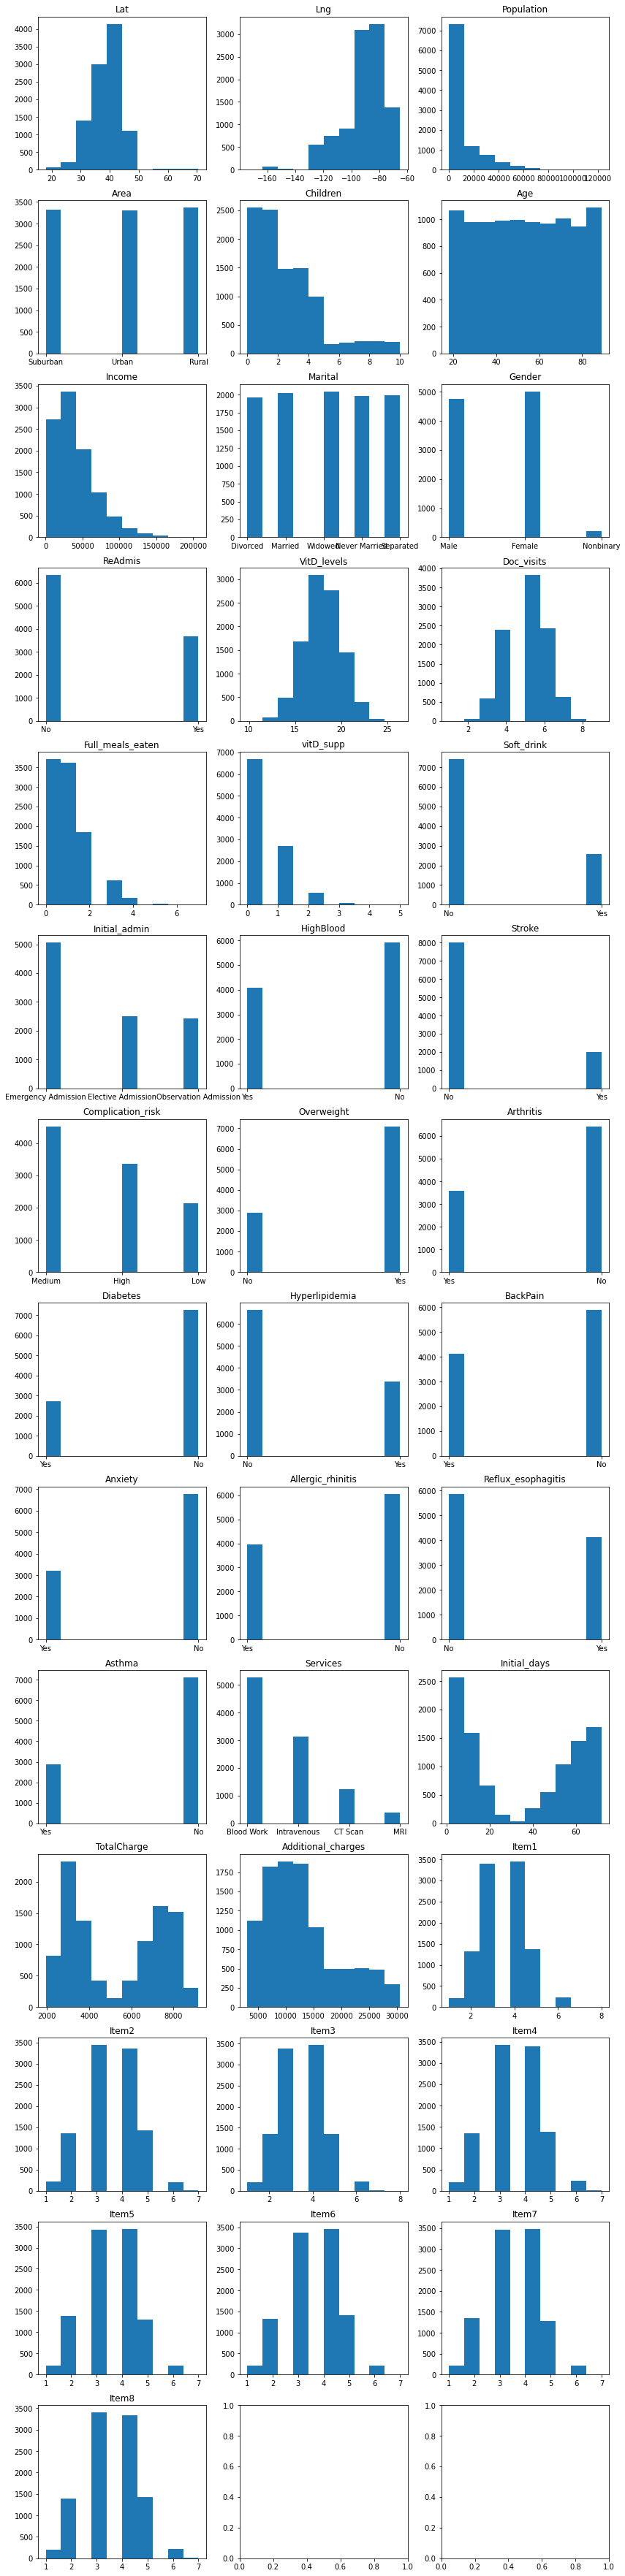

In [9]:
#Univariate distributions of all independent variables
fig, ax = plt.subplots(14, 3, sharey=False, figsize=(14, 64))

axi = 0
for i in np.r_[8:12, 14:50]:
    ax.flatten()[axi].hist(data.iloc[:, i])
    ax.flatten()[axi].set_title(data.columns[i])
    axi += 1

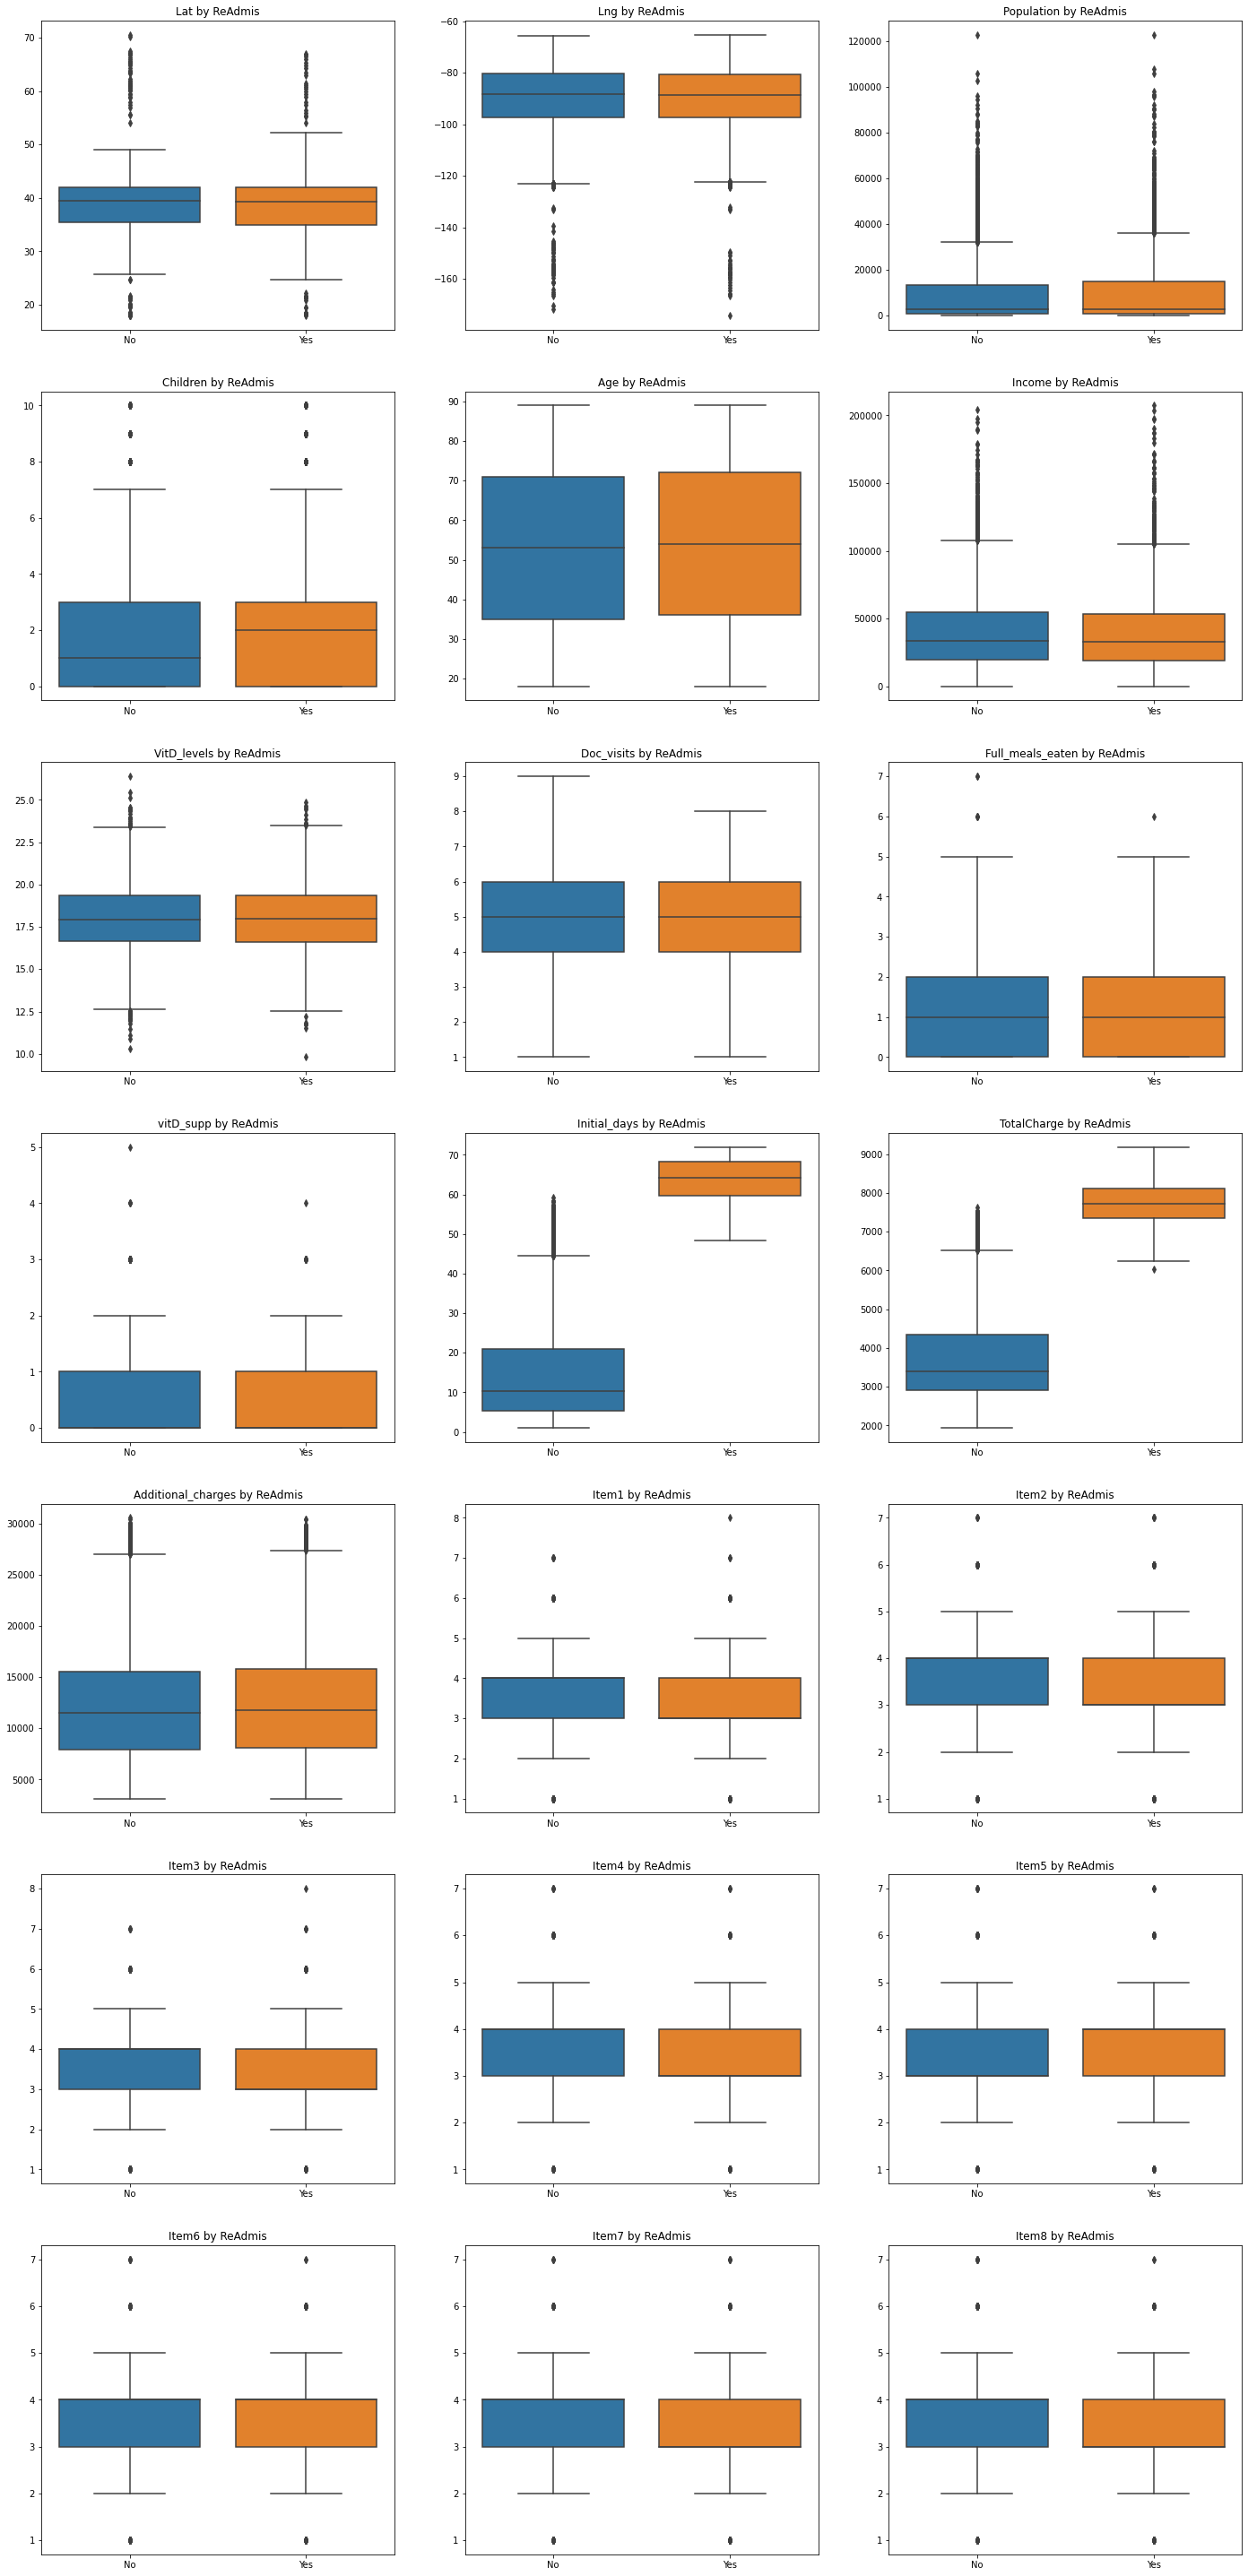

In [10]:
#Bivariate distributions for independent variable vs. the dependent variable
fig, ax = plt.subplots(7, 3, sharey=False, figsize=(24,52))

axi = 0
for i in np.r_[8:11, 14:17, 20:24, 39:50]:
    sns.boxplot(x=data['ReAdmis'], y=data.iloc[:, i], ax=ax.flatten()[axi])
    ax.flatten()[axi].set_title(data.columns[i] + ' by ReAdmis')
    ax.flatten()[axi].set_xlabel('')
    ax.flatten()[axi].set_ylabel('')
    axi += 1

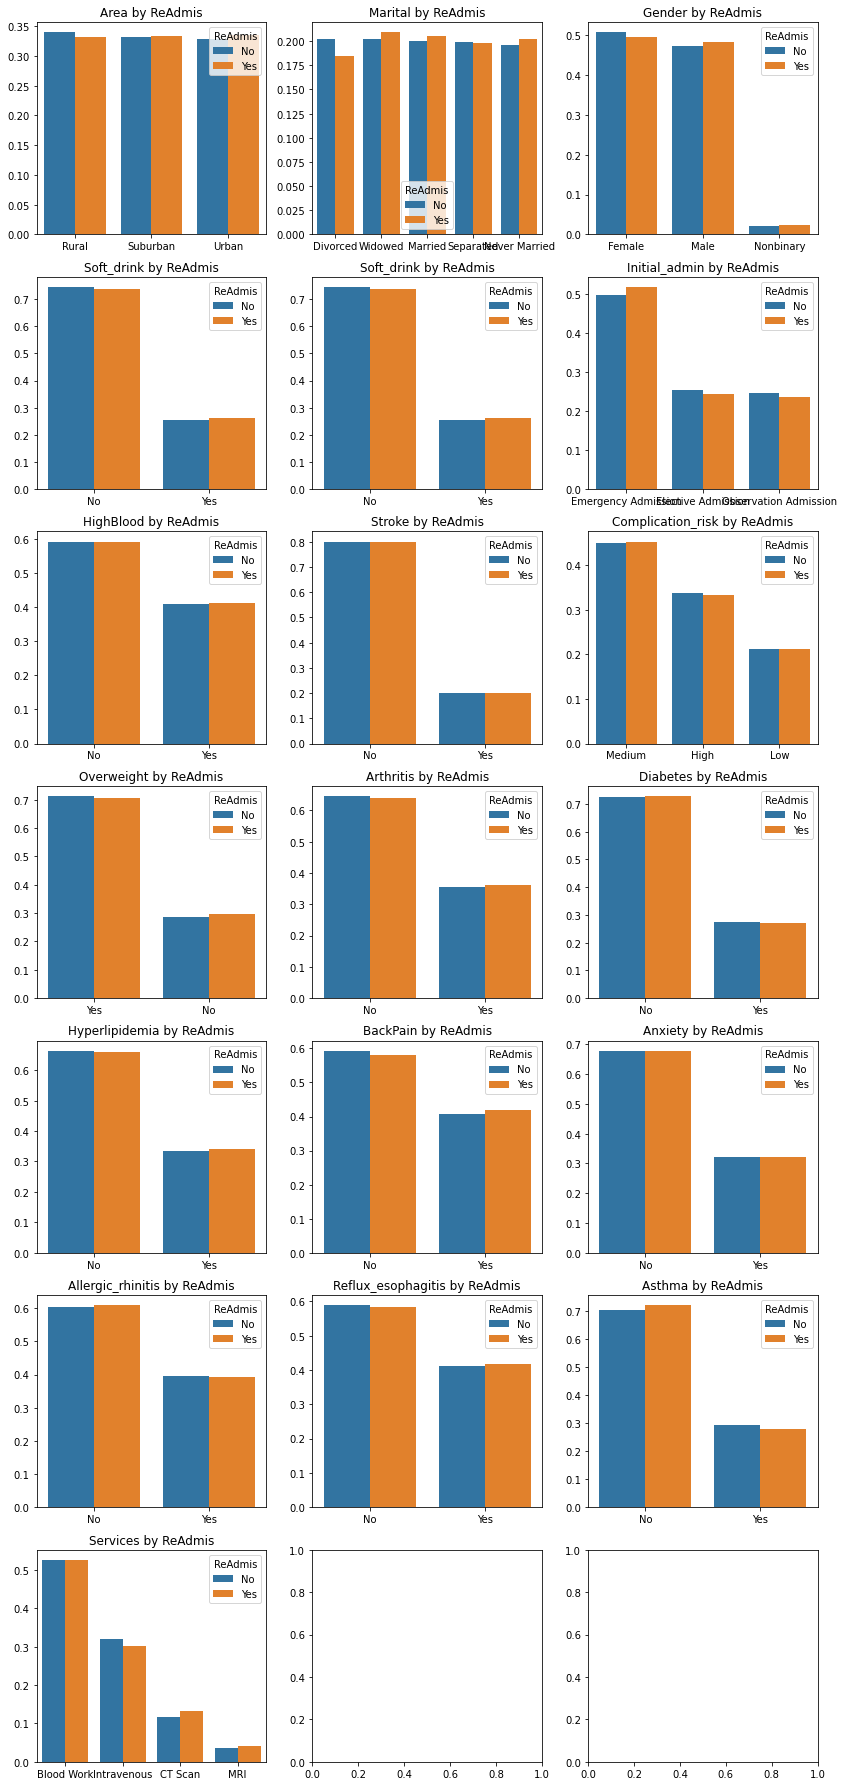

In [11]:
#Bivariate distributions continued
fig, ax = plt.subplots(7, 3, sharey=False, figsize=(14,32))

axi = 0
for i in np.r_[11, 17, 18, 24, 24:39]:
    x = data.columns[i]
    y = 'proportion'
    hue = 'ReAdmis'
    hue_order = [0, 1]
    
    (data[x]
    .groupby(data[hue])
    .value_counts(normalize=True)
    .rename(y)
    .reset_index()
    .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue, ax=ax.flatten()[axi]))
    
    ax.flatten()[axi].set_title(data.columns[i] + ' by ReAdmis')
    ax.flatten()[axi].set_xlabel('')
    ax.flatten()[axi].set_ylabel('')
    axi += 1

In [12]:
#Divide prepared data into predictors (X) and target (y)
X = data_clean.drop('ReAdmis', axis=1).copy()
y = data_clean['ReAdmis'].copy()
#Add constant
X = add_constant(X)
#Instantiate and fit logistic model
log_reg_init = sm.Logit(y, X).fit()
log_reg_init.summary()

Optimization terminated successfully.
         Current function value: 0.032558
         Iterations 14


C:\Users\joshu\anaconda3\envs\jupyer-DS\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ReAdmis   No. Observations:                 9123
Model:                          Logit   Df Residuals:                     9077
Method:                           MLE   Df Model:                           45
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.9506
Time:                        13:14:01   Log-Likelihood:                -297.03
converged:                       True   LL-Null:                       -6013.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -84.2990      5.153    -16.359      0.000     -94.399     -74.199
Lat                       1.7082      0.670      2.549      0.011       0.395       3.021
Lng                       0.0749      0.862      0.087      0.931      -1.615       1.765
Population                1.0776      0.978      1.102      0.271      -0.840       2.995
Children                  0.7583      0.482      1.572      0.116      -0.187       1.704
Age                      -0.0954      1.127     -0.085      0.933      -2.304       2.113
Income                    0.1979      0.806      0.246      0.806      -1.381       1.777
VitD_levels               0.7826      0.867      0.902      0.367      -0.917       2.482
Doc_visits                0.0914      0.827      0.111      0.912      -1.529       1.711
Full_meals_eaten         -0.3780      0.789     -0.479      0.632      -1.924       1.168
vitD_supp                -0.4082      0.884     -0.462      0.644      -2.141       1.324
Initial_days            106.0270      7.731     13.714      0.000      90.874     121.180
TotalCharge               0.7867      5.219      0.151      0.880      -9.443      11.016
Additional_charges        0.7289      1.810      0.403      0.687      -2.818       4.276
Item1                    -0.2185      1.118     -0.195      0.845      -2.410       1.973
Item2                     1.7517      0.885      1.979      0.048       0.017       3.486
Item3                    -1.2461      0.934     -1.334      0.182      -3.077       0.585
Item4                     0.2853      0.726      0.393      0.694      -1.138       1.709
Item5                    -0.5565      0.759     -0.733      0.463      -2.044       0.931
Item6                    -0.2319      0.799     -0.290      0.772      -1.798       1.335
Item7                     0.6890      0.728      0.947      0.344      -0.737       2.115
Item8                    -0.9668      0.685     -1.411      0.158      -2.310       0.376
Marital_Married           0.1657      0.351      0.473      0.636      -0.522       0.853
Marital_Never Married     0.5590      0.363      1.539      0.124      -0.153       1.271
Marital_Separated        -0.0749      0.361     -0.208      0.835      -0.782       0.632
Marital_Widowed           0.1218      0.356      0.343      0.732      -0.575       0.819
Gender_Male               0.0931      0.223      0.418      0.676      -0.344       0.530
Gender_Nonbinary          0.6930      0.792      0.875      0.381      -0.858       2.244
Services_CT Scan          1.7293      0.396      4.366      0.000       0.953       2.506
Services_Intravenous     -0.0833      0.245     -0.340      0.734      -0.564       0.397
Services_MRI              2.6171      0.533      4.911      0.000       1.573       3.662
Soft_drink                0.2899      0.257      1.127      0.260      -0.214       0.794
HighBlood                 0.5937      0.611      0.971      0.332      -0.605       1.792
S

<AxesSubplot:>

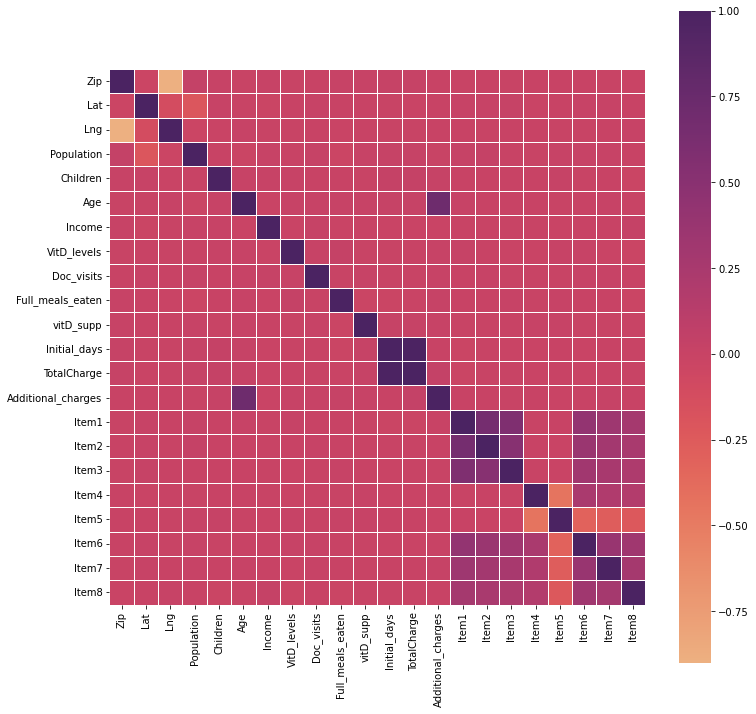

In [13]:
#Heat map of correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(data.iloc[:, 4:50].corr(), linewidths=1, linecolor='white', cmap=sns.color_palette("flare", as_cmap=True), square=True)

In [22]:
#Drop highly correlated variables
X2 = X.drop(['TotalCharge', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'], axis=1).copy()

In [15]:
#Model reduction strategy is saved within a function for reusability
def reduce_model(X, y, sig_lvl):#Accepts predictor df, target series, and significance level
    log_reg = sm.Logit(y, X)#Creates model
    model = log_reg.fit()#Fits model
    p_val = model.pvalues.to_list()
    var = X.columns.to_list()

    while max(p_val) >= sig_lvl:#Breaks once all predictor variables are statistically significant
        for i in range(len(var)):
            if p_val[i] == max(p_val):
                X.drop(var[i], axis=1, inplace=True)#Drops variable with highest, non-significant p-value
        log_reg = sm.Logit(y, X)#Recreates model
        model = log_reg.fit()#Refits model
        p_val = model.pvalues.to_list()
        var = X.columns.to_list()
        
    return model, X#Returns a reduced model and the corresponding predictor variables

In [16]:
model_final, X_final = reduce_model(X2, y, 0.05)
model_final.summary()

Optimization terminated successfully.
         Current function value: 0.033086
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033086
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033086
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033087
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033089
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033092
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033096
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033104
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033115
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ReAdmis   No. Observations:                 9123
Model:                          Logit   Df Residuals:                     9112
Method:                           MLE   Df Model:                           10
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.9471
Time:                        13:14:03   Log-Likelihood:                -317.96
converged:                       True   LL-Null:                       -6013.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -76.7572      4.338    -17.693      0.000     -85.260     -68.254
Initial_days         99.0859      5.590     17.726      0.000      88.130     110.042
Services_CT Scan      1.7613      0.360      4.893      0.000       1.056       2.467
Services_MRI          2.4744      0.505      4.900      0.000       1.485       3.464
HighBlood             0.7907      0.212      3.734      0.000       0.376       1.206
Stroke                1.5292      0.268      5.704      0.000       1.004       2.055
Arthritis            -1.2377      0.224     -5.533      0.000      -1.676      -0.799
Anxiety              -0.8675      0.223     -3.896      0.000      -1.304      -0.431
Asthma               -1.2821      0.237     -5.408      0.000      -1.747      -0.817
Initial_admin         2.4422      0.280      8.737      0.000       1.894       2.990
Complication_risk     1.8416      0.297      6.202      0.000       1.260       2.424
=====================================================================================

Possibly complete quasi-separation: A fraction 0.81 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [17]:
#List of removed variables
print([x for x in X.columns.to_list() if x not in X_final.columns.to_list()])

['Lat', 'Lng', 'Population', 'Children', 'Age', 'Income', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp', 'TotalCharge', 'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8', 'Marital_Married', 'Marital_Never Married', 'Marital_Separated', 'Marital_Widowed', 'Gender_Male', 'Gender_Nonbinary', 'Services_Intravenous', 'Soft_drink', 'Overweight', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Area']


In [18]:
#Initial model confusion matrix
log_reg_init.pred_table()

array([[5682.,   62.],
       [  61., 3318.]])

In [19]:
#Final model confusion matrix
model_final.pred_table()

array([[5678.,   66.],
       [  58., 3321.]])

In [20]:
#Predictions of final model
model_final.predict(X_final).to_list()

[6.425822161090203e-28,
 2.7143904697223423e-23,
 4.940986616185922e-31,
 1.1659355242947253e-33,
 3.828266109318979e-33,
 1.1526345407901607e-30,
 1.0933071465035628e-28,
 4.106813423365349e-25,
 7.326241514115066e-30,
 4.94394086045855e-32,
 7.554752471601485e-32,
 8.297449041166499e-28,
 1.0416203321917294e-30,
 5.831274724816067e-32,
 1.6499990639864925e-33,
 3.444127434703866e-33,
 1.6175625513722707e-32,
 4.900823626819943e-30,
 6.404619075115286e-29,
 3.6499801976840405e-28,
 1.0636136572159984e-30,
 8.329835752660624e-26,
 1.527634271562488e-22,
 2.573968554968681e-28,
 4.860553564181159e-29,
 7.082431782266129e-22,
 5.287456422682586e-26,
 1.0125486969480845e-25,
 5.494039438554215e-31,
 4.4262174950459954e-18,
 2.8450701366406856e-30,
 8.69244439941904e-28,
 5.383287931396745e-27,
 2.3044797451718728e-32,
 1.6792459803879815e-26,
 4.928705129739464e-25,
 3.879933264894059e-27,
 3.393114941138485e-32,
 3.367817497408879e-28,
 1.053748458345059e-27,
 1.225994599133899e-25,
 1.7

In [21]:
#Final model coefficients
model_final.params

const               -76.757150
Initial_days         99.085875
Services_CT Scan      1.761314
Services_MRI          2.474357
HighBlood             0.790651
Stroke                1.529204
Arthritis            -1.237706
Anxiety              -0.867477
Asthma               -1.282136
Initial_admin         2.442183
Complication_risk     1.841626
dtype: float64